# Baryon-Baryon Correlator

First we import stuff, and define all of the objects needed to create/annihilate baryons.  In the future this will be read in from a text file that is generated by some group theory code to construct operators in an automated way.  

In [2]:
import sys
import os

sys.path.append(os.getcwd()[:-9])

from WickContractions.ops.operator import *
from WickContractions.ops.elemental import *
from WickContractions.ops.quarks import *
from WickContractions.ops.commuting import *
from WickContractions.corrs.diagram import *
from WickContractions.wick.utilities import *
from WickContractions.wick.contract import *
from WickContractions.laph.diagram import *

In [38]:
c0=EpsilonTensor(['c0','c1','c2','c3'])
c1=SpinMatrix('X1',['s0','s1','s2','s3'])
                  
q0=Quark(False,'u','s0','c0','tf','x1')
q1=Quark(False,'d','s1','c1','tf','x1')
q2=Quark(False,'u','s2','c2','tf','x1')
q3=Quark(False,'d','s3','c3','tf','x1')


annihilate_baryon = Operator([ElementalOperator(1,[c0,c1],[q0,q1,q2,q3])])

c6=EpsilonTensor(['c4','c5','c6','c7'])
c7=SpinMatrix('X2',['s4','s5','s6','s7'])

q6=Quark(True,'d','s4','c4','ti','x2')
q7=Quark(True,'u','s5','c5','ti','x2')
q8=Quark(True,'d','s6','c6','ti','x2')
q9=Quark(True,'u','s7','c7','ti','x2')

create_baryon = Operator([ElementalOperator(1,[c6,c7],[q6,q7,q8,q9])])

Now do the contractions and store in Laph subspace

In [39]:
res = contract(annihilate_baryon, create_baryon).diagrams

for i in range(len(res)):
    res[i]=LDiagram(res[i])


print("B->B correlator has {} diagrams".format(len(res)))

B->B correlator has 4 diagrams


Now we can apply laph smearing to the quarks.  We print out the B->B diagrams explicitly since there are only four. 

In [40]:
#testing a more generic way to make blocks.
tst=copy.deepcopy(res)
for d in tst:
    d.create_baryon_blocks()
    #d.create_block('delta','M') # should allow this code to handle any number of mesons/baryons
    d.short_props()
    
for d in tst:
    #print(d)
    d.create_baryon_source()       # not NC agnostic at the moment.
                                   # not generalized to accomodate mesons + baryons
    print(d)
    print()

-1.0 B*(X1,tf,ti)_{5 6 7 4}B(X2,ti)_{4 5 6 7}

1.0 B*(X1,tf,ti)_{5 4 7 6}B(X2,ti)_{4 5 6 7}

1.0 B*(X1,tf,ti)_{7 6 5 4}B(X2,ti)_{4 5 6 7}

-1.0 B*(X1,tf,ti)_{7 4 5 6}B(X2,ti)_{4 5 6 7}



### Quick Check of computation

I just did a quick check of the loop cost and printed out each contraction that needed to be done.  The latter notation is used in Eigen::Tensor or Fastor.

In [41]:
#brute force counting.
costs = {}
for d in tst:
    nested_sums = 0
    for idx in d.commuting[0].indices[0:4]:
        if(idx in d.commuting[1].indices):
            nested_sums+=1
    if nested_sums in costs:
        costs[nested_sums]+=1
    else:
        costs[nested_sums]=1
print('total loops:')
for k,v in costs.items():
    print('  {}*N^{}'.format(v,k))

total loops:
  4*N^4


In [42]:
for d in tst:
    contractions = []
    for i,idx in enumerate(d.commuting[0].indices[0:4]):
        j=d.commuting[1].indices.index(idx)
        contractions.append([i,j])
    print(contractions)

[[0, 1], [1, 2], [2, 3], [3, 0]]
[[0, 1], [1, 0], [2, 3], [3, 2]]
[[0, 3], [1, 2], [2, 1], [3, 0]]
[[0, 3], [1, 0], [2, 1], [3, 2]]


## Diagram Plots

Just making some quick visuals of the topologies.

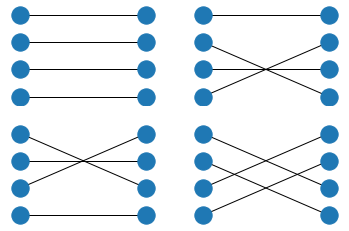

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import copy

tst=copy.deepcopy(res)
for d in tst:
    d.create_baryon_blocks()
    d.short_props()

for d in tst:
    d.create_baryon_source()
    #print(d)
    
G = nx.Graph()
G.add_node('4ti',pos=(1,1))
G.add_node('5ti',pos=(1,2))
G.add_node('6ti',pos=(1,3))
G.add_node('7ti',pos=(1,4))
G.add_node('4tf',pos=(5,1))
G.add_node('5tf',pos=(5,2))
G.add_node('6tf',pos=(5,3))
G.add_node('7tf',pos=(5,4))
pos=nx.get_node_attributes(G,'pos')

xdim = int(len(tst)/2)
ydim = int(len(tst)-len(tst)/2)
for iplt,d in enumerate(tst):
    Gtmp=G.copy()
    pos=nx.get_node_attributes(G,'pos')

    for i,idx in enumerate(d.commuting[0].indices):
        Gtmp.add_edge(idx+d.commuting[0].arguments[1],
                   d.commuting[1].indices[i]+tst[0].commuting[0].arguments[2])
    plt.subplot(xdim,ydim,iplt+1)
    nx.draw(Gtmp,pos)
#plt.savefig('baryon_correlator.png')
plt.show()